In [0]:
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [3]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 6.2MB/s 


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# follwing is a sharable link of the file that is to be uploaded from google drive
# https://drive.google.com/open?id=14vk6gkrp1G9QLEq3zGCutQu1LhqDiQ1X
# this id of this file is need to be entered in the id_of_file as string
id_of_file = '1QbBYjDAwhSwVLl-7BPqeHz_mdw8-RhCd'
some_var = drive.CreateFile({'id':id_of_file})
some_var.GetContentFile('all.zip')

In [6]:
!unzip all.zip

Archive:  all.zip
  inflating: merchants.csv           
  inflating: sample_submission.csv   
  inflating: new_merchant_transactions.csv  
  inflating: test.csv                
  inflating: train.csv               
  inflating: Data_Dictionary.xlsx    
  inflating: historical_transactions.csv  


In [64]:
!ls

adc.json		     merchants.csv		    test.csv
all.zip			     new_merchant_transactions.csv  train.csv
Data_Dictionary.xlsx	     sample_data
historical_transactions.csv  sample_submission.csv


In [0]:
historical_df = pd.read_csv('historical_transactions.csv')

In [0]:
train_df = pd.read_csv('train.csv')

In [66]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [0]:
''' preprocessing of train_df only withouting merge '''

# converting to datetime
train_df['first_active_month'] = pd.to_datetime(train_df['first_active_month'])

# sorting to find the most rescent active month card 
train_df.sort_values(by='first_active_month')

# 2018-02 is the most rescent month
train_df['difference_between_most_recent_transaction'] = pd.to_datetime('2018-02-01') - train_df['first_active_month']

# creating the thime delta with reference as most rescent active month 
train_df['difference_between_most_recent_transaction'] = train_df['difference_between_most_recent_transaction'].apply(lambda x: x.days)

# normalizing time delta around mean new_x = (x - mean)/std
mu = train_df['difference_between_most_recent_transaction'].mean()
sigma = train_df['difference_between_most_recent_transaction'].std()
train_df['difference_between_most_recent_transaction'] = (train_df['difference_between_most_recent_transaction'] - mu) /sigma

# creating dummies for feature_ 1 and 2
train_df = train_df.join(pd.get_dummies(train_df['feature_1'], prefix='feature_1').join(pd.get_dummies(train_df['feature_2'], prefix='feature_2')))

# removing original feature_ 1and 2 as they are not need anymore
train_df.drop(columns=['feature_1', 'feature_2'], axis=1, inplace=True)

# creating features for first active month and year
train_df['month'] = train_df['first_active_month'].apply(lambda x: x.month)
train_df['year'] = train_df['first_active_month'].apply(lambda x: x.year)

# dropped un-necessary columns
train_df.drop(columns=['first_active_month', 'card_id'], axis=1, inplace=True)

In [68]:
train_df.head()

,feature_3,target,difference_between_most_recent_transaction,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,month,year
0,1,-0.820283,-0.466375,0,0,0,0,1,0,1,0,6,2017
1,0,0.392913,0.047738,0,0,0,1,0,1,0,0,1,2017
2,0,0.688056,0.568659,0,1,0,0,0,0,1,0,8,2016
3,0,0.142495,-0.779609,0,0,0,1,0,0,0,1,9,2017
4,0,-0.159749,-0.987296,1,0,0,0,0,0,0,1,11,2017


In [0]:
historical_df = historical_df.merge(train_df, on='card_id', how='right')

KeyError: ignored

In [0]:
historical_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,first_active_month,feature_1,feature_2,feature_3,target
0,N,C_ID_5037ff576e,322,N,1,B,278,M_ID_b61c7d1be0,-3,-0.595260,2017-09-07 20:57:19,3.0,11,37,2017-01,5,1,1,-2.352713
1,Y,C_ID_5037ff576e,138,N,1,B,307,M_ID_fe69229f24,-4,1.189469,2017-08-14 15:46:08,1.0,15,19,2017-01,5,1,1,-2.352713
2,Y,C_ID_5037ff576e,138,N,1,B,705,M_ID_efc106141c,-9,-0.640069,2017-03-05 14:57:51,1.0,15,33,2017-01,5,1,1,-2.352713
3,Y,C_ID_5037ff576e,226,N,1,B,307,M_ID_708022307c,-4,-0.652256,2017-08-15 10:45:28,1.0,16,19,2017-01,5,1,1,-2.352713
4,Y,C_ID_5037ff576e,330,N,1,B,705,M_ID_393b4b8cec,-9,-0.674210,2017-03-26 20:00:31,3.0,17,33,2017-01,5,1,1,-2.352713


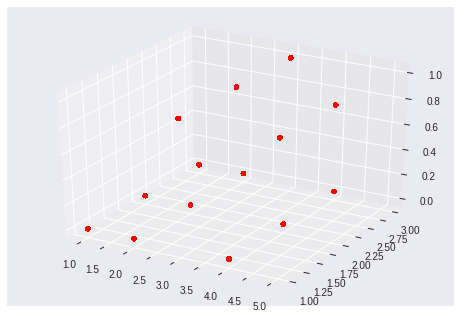

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_df['feature_1'], train_df['feature_2'], train_df['feature_3'], c='r', marker='o')
plt.show()

In [0]:
function_dict = {
    'installments':{
        'avg_installments':'mean',
        'median_installments':'median',
        'max_installments':'max',
        'var_installments':'var'
    }
}

In [0]:
s = historical_df.groupby('card_id').agg(function_dict)

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [0]:
# seperated training data for splitting
y = train_df[['target']]
train_df.drop(columns='target', axis=1, inplace=True)
X = train_df

In [0]:
# introducing polynomial features of max degree 2
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

In [0]:
# splitting dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

**LINEAR REGRESSION FROM HERE**

In [72]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred = reg.predict(X_test)

# print(f'coefficients of regression are {reg.coef_}')
print(f'root mean squared error score is {sqrt(mean_squared_error(y_test, pred))}')

root mean squared error score is 3.8368324367222724


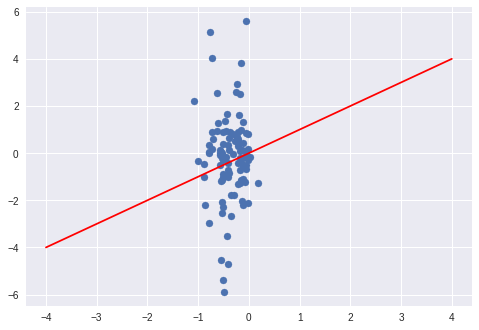

In [74]:
plt.scatter(pred[:100], y_test[:100])
x, y = [-4,-3,-2,-1,0,1,2,3,4], [-4,-3,-2,-1,0,1,2,3,4]
plt.plot(x, y, c='r')
plt.show()

**XGBOOST FROM HERE**

In [0]:
import xgboost as xgb

In [76]:
xgdmat = xgb.DMatrix(X_train,y_train)
our_params = {'eta':0.1,
             'seed':0,
             'subsample':0.8,
             'colsample_bytree':0.8,
             'objective':'reg:linear',
             'max_depth':4,
             'min_child_weight':1
         }
final_gb = xgb.train(our_params,xgdmat)
tesdmat = xgb.DMatrix(X_test)
y_pred = final_gb.predict(tesdmat)
print(f'the root mean squared error is {sqrt(mean_squared_error(y_test, y_pred))}')

the root mean squared error is 3.849493928107626


**SUBMISSION**

In [0]:
sub_df = pd.read_csv('test.csv')

In [0]:
# converting to datetime
sub_df['first_active_month'] = pd.to_datetime(sub_df['first_active_month'])

# sorting to find the most rescent active month card 
# sub_df.sort_values(by='first_active_month')

# filling NaNs
sub_df.fillna(pd.to_datetime('2018-01-01'))

# 2018-02 is the most rescent month
sub_df['difference_between_most_recent_transaction'] = pd.to_datetime('2018-01-01') - sub_df['first_active_month']

# creating the thime delta with reference as most rescent active month 
sub_df['difference_between_most_recent_transaction'] = sub_df['difference_between_most_recent_transaction'].apply(lambda x: x.days)

# normalizing time delta around mean new_x = (x - mean)/std
mu = sub_df['difference_between_most_recent_transaction'].mean()
sigma = sub_df['difference_between_most_recent_transaction'].std()
sub_df['difference_between_most_recent_transaction'] = (sub_df['difference_between_most_recent_transaction'] - mu) /sigma

# creating dummies for feature_ 1 and 2
sub_df = sub_df.join(pd.get_dummies(sub_df['feature_1'], prefix='feature_1').join(pd.get_dummies(sub_df['feature_2'], prefix='feature_2')))

# removing original feature_ 1and 2 as they are not need anymore
sub_df.drop(columns=['feature_1', 'feature_2'], axis=1, inplace=True)

# creating features for first active month and year
sub_df['month'] = sub_df['first_active_month'].apply(lambda x: x.month)
sub_df['year'] = sub_df['first_active_month'].apply(lambda x: x.year)

# dropped un-necessary columns
sub_df.drop(columns=['first_active_month', 'card_id'], axis=1, inplace=True)

In [0]:
# TO DO
sub_df = sub_df.fillna(0)

In [0]:
sub_df = poly.fit_transform(sub_df)

In [0]:
sub_dmat = xgb.DMatrix(sub_df)
pred_xgb = final_gb.predict(sub_dmat)

In [0]:
final_sub = pd.read_csv('sample_submission.csv')
final_sub['target'] = pred_xgb

In [0]:
final_sub.to_csv('final_submission.csv', index_label=False, index=False)

In [0]:
# sub using regression
pred = reg.predict(sub_df)
final_sub = pd.read_csv('sample_submission.csv')
final_sub['target'] = pred

In [0]:
final_sub.to_csv('final_submission.csv', index_label=False, index=False)